## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd     
import re 
import seaborn as sns
import seaborn.objects as so
from src.utils import DataProcessing as dp 
# TODO finish transfering functions to DataProcessing.py

## import data and cleaning

In [6]:

PATH= r"/Users/michaelschaid/GitHub/house_prediction/data/AmesHousing.tsv"
data = pd.read_csv(PATH, delimiter='\t')

def clean_data(df):

    def null_counts(df: pd.DataFrame, upper_lim: float, lower_lim=0) -> tuple:
        """Calculate the percentage of missing values in each column and return:
                a list of column names that should be imputed. 
                a list of column names that should be dropped.
        """
    # calculate missing values percentage and return
        null_counts = pd.DataFrame(
            df.isnull().sum()/df.shape[0], columns=['null_counts'])
        cols_impute = null_counts.query(
            "null_counts > @lower_lim & null_counts < @upper_lim").index.to_list()
        cols_drop = null_counts.query(
            "null_counts >= @upper_lim").index.to_list()
        return cols_impute, cols_drop
    # null_cols = null_counts(df, 0.05)

    def to_category(df_) -> list:
        return df_.astype({c: 'category' for c in df_.select_dtypes('object').columns})

    def group_col_names(df, term):
        return [col for col in df.columns if re.search(term, col)]

    return (df
            # drop columns with more than 5% missing values
            .drop(columns=null_counts(df, 0.05)[1])
            # drop identifier columns that are not useful for modeling
            .drop(columns=['PID', 'Order'])
            # impute numerical columns and fill with mean value
            .fillna(value={c: df[c].mean() for c in df.select_dtypes('number').columns})
            # rename columns to lowercase and replace spaces with underscores
            .rename(lambda col: col.replace(' ', '_').lower(), axis=1)
            # convert object columns to category
            .pipe(lambda df_: to_category(df_))
            .assign(year_until_remod=lambda df_: df_['year_remod/add'] - df_['year_built'],  # years between remod and built
                    total_sf=lambda df_: df_[group_col_names(df_, 'sf')].sum(
                        axis=1),  # total square footage
                    total_area=lambda df_: df_[group_col_names(
                        df_, 'area')].sum(axis=1),  # total area
                    )
            )

homes =clean_data(data)
homes

,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,...,pool_area,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice,year_until_remod,total_sf,total_area
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,5,2010,WD,Normal,215000,0,4088.0,34066.0
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,6,2010,WD,Normal,105000,0,2800.0,13248.0
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,12500,6,2010,WD,Normal,172000,0,4416.0,16016.0
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,4,2010,WD,Normal,244000,0,6330.0,13792.0
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,3,2010,WD,Normal,189900,1,3731.0,15941.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,0,0,3,2006,WD,Normal,142500,0,3129.0,9528.0
2926,20,RL,8885,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,...,0,0,6,2006,WD,Normal,131000,0,2794.0,10271.0
2927,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0,700,7,2006,WD,Normal,132000,0,2906.0,11411.0
2928,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,...,0,0,4,2006,WD,Normal,170000,1,4445.0,11817.0


### Basic EDA of numerical features

#### year remodeled, year built, and  $\Delta$ year_remod - year_built are correlated to sales price

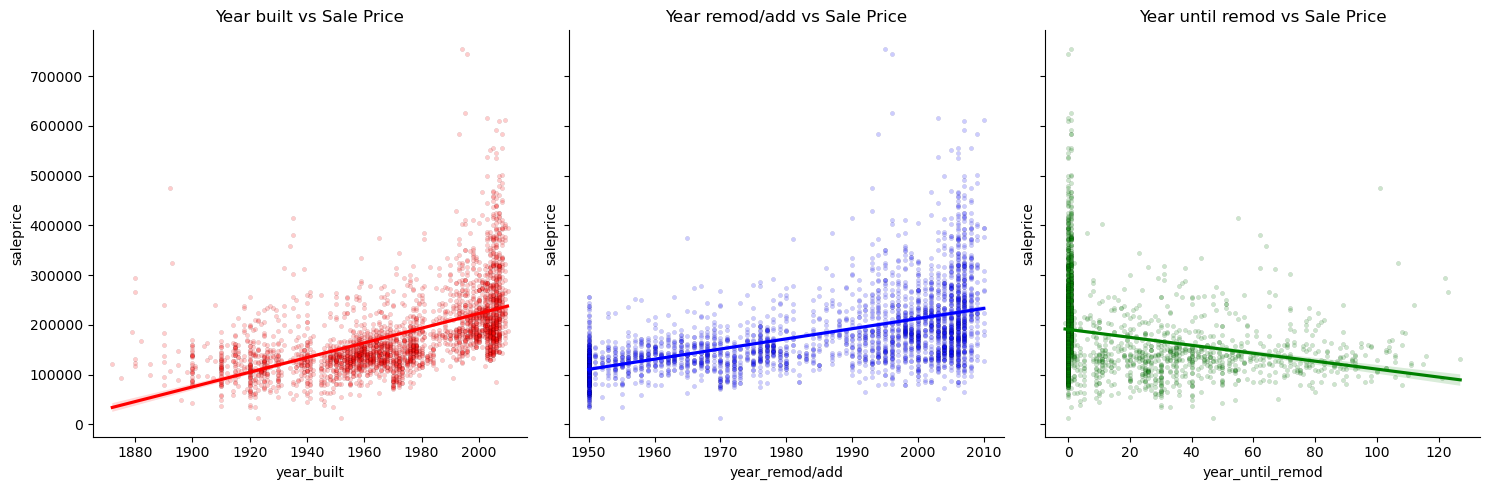

In [29]:
def year_plot(col, ax, color):
    #  function to make plots for year columns
    kws_={"s": 10,
          'alpha': 0.2,
          'edgecolor': 'black',
          'linewidth': 0.2
          }
    sns.regplot(x=col, y='saleprice', data=homes, ax=ax, color=color, scatter_kws=kws_)
    sns.despine()
    ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')

#  figure generation
fig, ax = plt.subplots(figsize=(15,5), ncols=3, sharey=True)
year_plot('year_built', ax[0], color='red')
year_plot('year_remod/add', ax[1], color='blue')
year_plot('year_until_remod', ax[2], color='green')
plt.tight_layout()
plt.show()

## Total area and total sf are superior predictors for saleprice. 

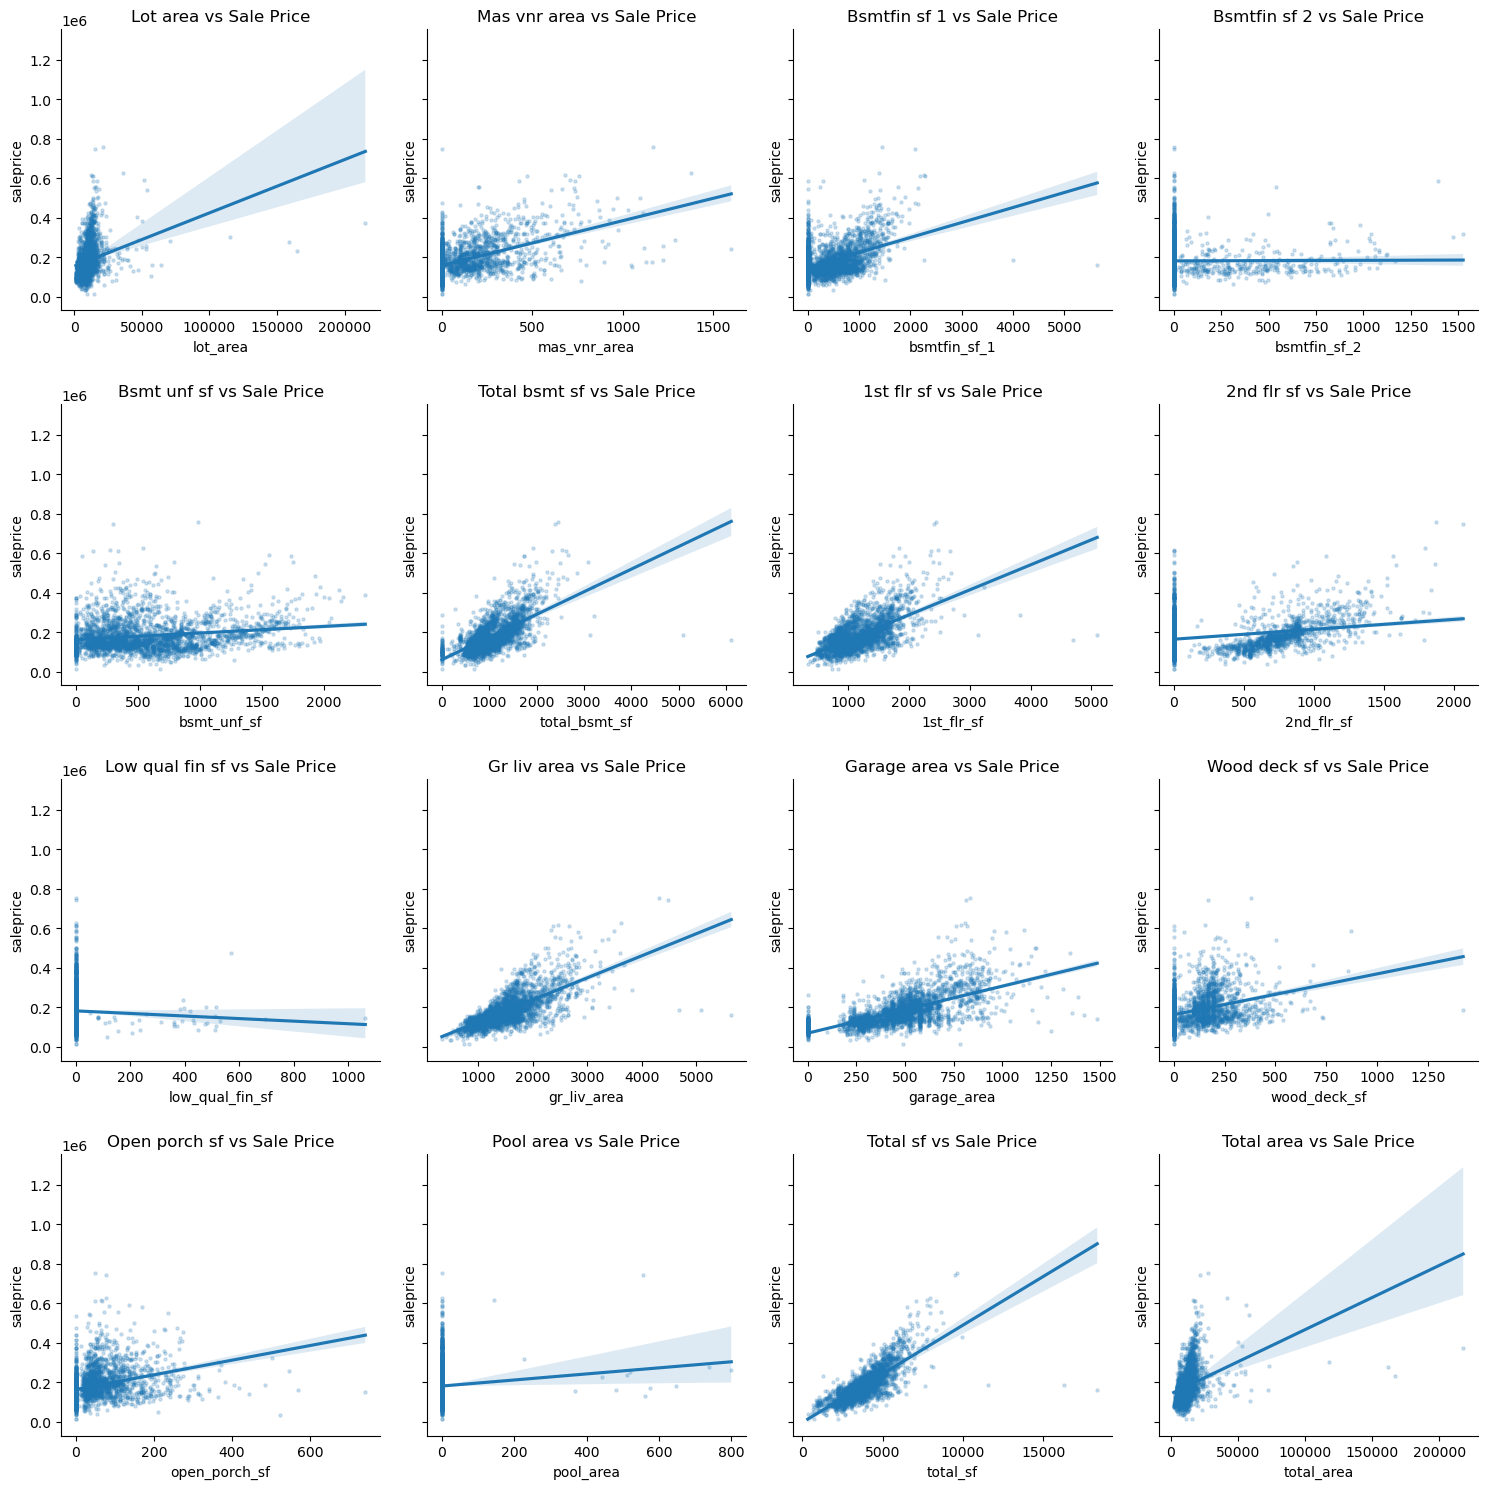

In [30]:
sqr_footage = [col for col in homes.columns if re.search(r'sf|area', col)] +['saleprice']

def make_reg_panel(cols):
    number_subplots = len(cols)-1
    grid_sqr= int(np.ceil(np.sqrt(number_subplots)))
    fig, ax = plt.subplots(figsize=(15,15), ncols=grid_sqr, nrows=grid_sqr, sharey=True)
    
    for col, ax in zip(cols, ax.flatten()):
        if col !='saleprice':
            kws_={"s": 5,'alpha': 0.2}
            sns.regplot(x=col, y='saleprice', data=homes, ax=ax, scatter_kws=kws_)
            ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')
            sns.despine(ax=ax)
    
    plt.tight_layout()
    plt.show()

make_reg_panel(sqr_footage)



### EDA of categorigcal features

### neighborhood correlates mildly with overall_qual and saleprice, but qual is greater predictor.

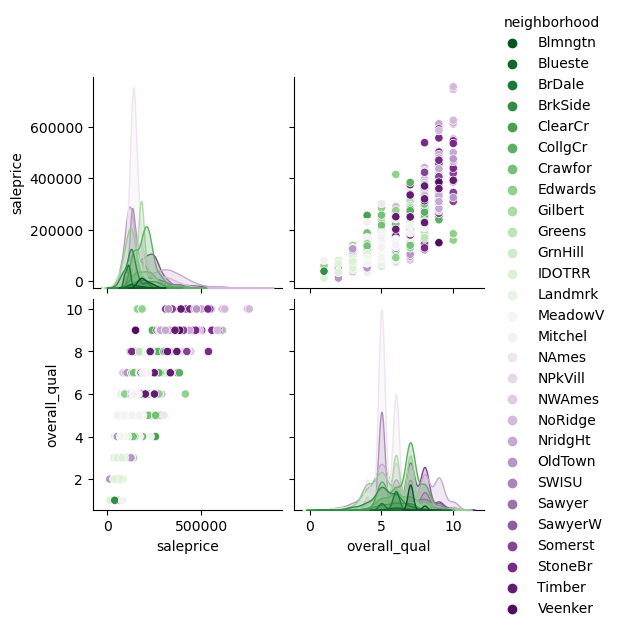

In [31]:
sns.pairplot(data=homes[['saleprice', 'overall_qual', 'neighborhood']], hue='neighborhood', palette='PRGn_r')

## Summary of Categorical Features

> Very few Categorical features have signifincat correlation with sale price and will likely be dropped
> although neighborhood has many categories, there is some degree of correlation with saleprice which makes sence 


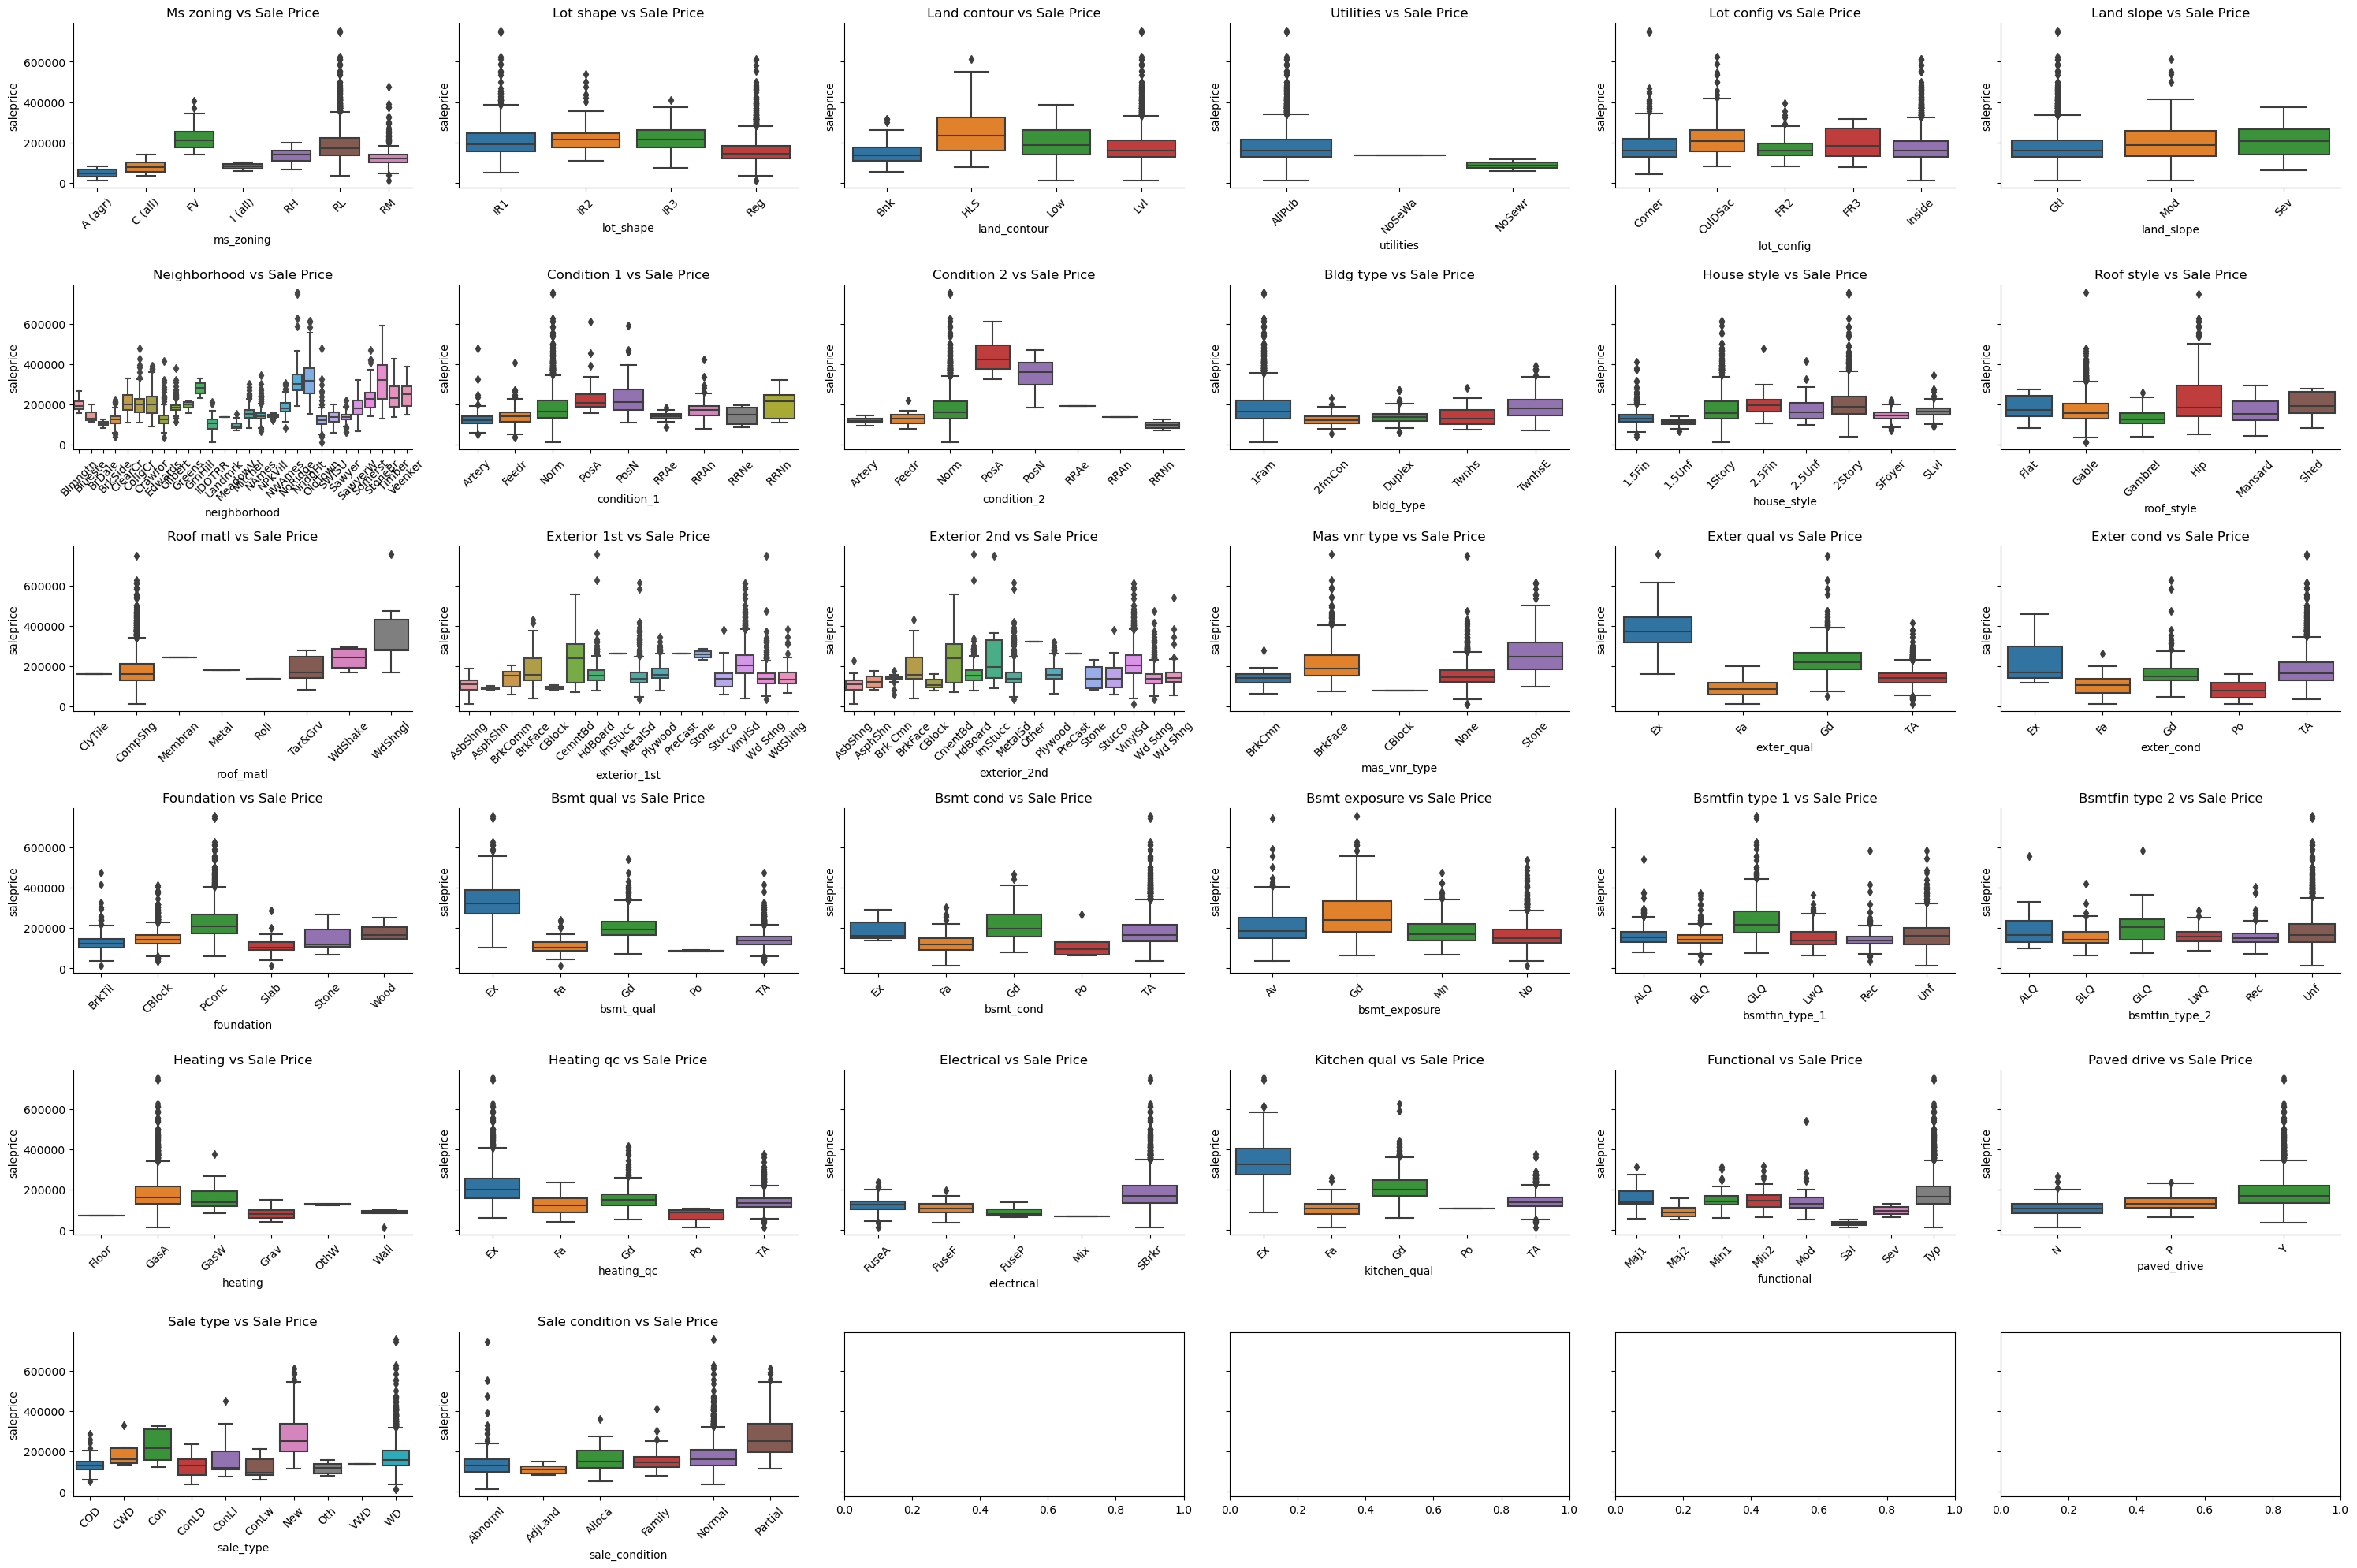

In [32]:
def plot_categorical(cat_threshold = 2):
    homes_cat = homes[homes.select_dtypes('category').columns.tolist() + ['saleprice']]
    homes_cat_gt5 = homes_cat[homes_cat.nunique()[homes_cat.nunique() > cat_threshold].index.to_list()].columns.to_list()
    panel_numb = len(homes_cat_gt5)-1
    grid_numb = int(np.ceil(np.sqrt(panel_numb)))
    
    fig, ax = plt.subplots(ncols=grid_numb, nrows=grid_numb, figsize=(30,20), sharey=True)
    for col, ax in zip(homes_cat_gt5, ax.flatten()):
        if col !='saleprice':
            sns.boxplot(x=col, y='saleprice', data=homes_cat, ax=ax)
            ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')
            sns.despine(ax=ax)
            ax.tick_params(axis='x', rotation=45)
            
    plt.tight_layout()
    plt.show()
    

   
plot_categorical()

## Extraction of neighborhood features and correlation analysis of all features to saleprice

In [33]:
def get_dummies(df, cols):
    cat_to_drop = df.select_dtypes('category').columns.tolist()

    cols_dummies = (pd.get_dummies(df[cols])
                    .rename(lambda c: c.lower(), axis=1)
                    )
    return (pd.concat([df, cols_dummies], axis=1)
               .drop(columns=cat_to_drop)
            )   
    
    
get_dummies(homes, cols='neighborhood')

,ms_subclass,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,...,noridge,nridght,oldtown,swisu,sawyer,sawyerw,somerst,stonebr,timber,veenker
0,20,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,...,0,0,0,0,0,0,0,0,0,0
1,20,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,0,0,0,0,0,0,0,0,0,0
2,20,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,0,0,0,0,0,0,0,0,0,0
3,20,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,...,0,0,0,0,0,0,0,0,0,0
4,60,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,7937,6,6,1984,1984,0.0,819.0,0.0,184.0,...,0,0,0,0,0,0,0,0,0,0
2926,20,8885,5,5,1983,1983,0.0,301.0,324.0,239.0,...,0,0,0,0,0,0,0,0,0,0
2927,85,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,...,0,0,0,0,0,0,0,0,0,0
2928,20,10010,5,5,1974,1975,0.0,1071.0,123.0,195.0,...,0,0,0,0,0,0,0,0,0,0


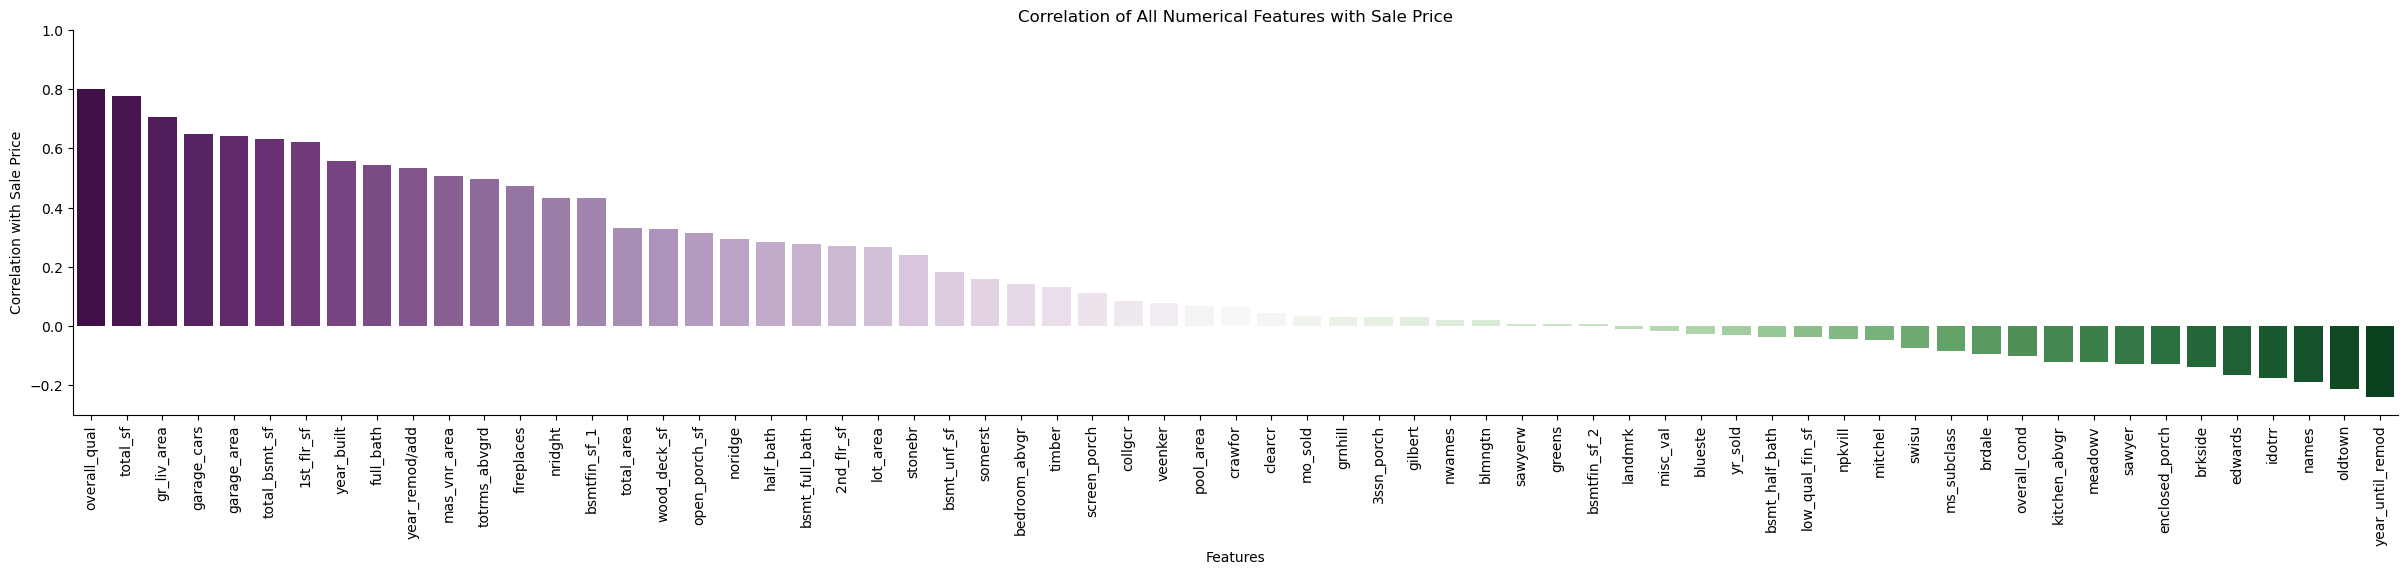

In [34]:


fig, ax = plt.subplots(figsize=(30, 5))
format = {
       'xlabel':'Features', 
       'ylabel':'Correlation with Sale Price',
       'title':'Correlation of All Numerical Features with Sale Price',
       "ylim": (-0.3, 1)    
       } 
sns.barplot(data=processed_corr.iloc[1:], x=list(processed_corr.iloc[1:].index), y='saleprice', palette='PRGn', ax=ax)

ax.set(**format)

plt.xticks(rotation=90)
# drawlines(*(0.3, -0.1))
sns.despine()
ax.annotate('lines indicate threshold criteria for feature selection', xy=(150, 1), xytext=(70, 0.5))
plt.show()

In [35]:


features = dp.select_features(processed_homes, lower_threshold = -0.1, upper_threshold= 0.3)

features

['overall_qual',
 'total_sf',
 'gr_liv_area',
 'garage_cars',
 'garage_area',
 'total_bsmt_sf',
 '1st_flr_sf',
 'year_built',
 'full_bath',
 'year_remod/add',
 'mas_vnr_area',
 'totrms_abvgrd',
 'fireplaces',
 'nridght',
 'bsmtfin_sf_1',
 'total_area',
 'wood_deck_sf',
 'open_porch_sf',
 'overall_cond',
 'kitchen_abvgr',
 'meadowv',
 'sawyer',
 'enclosed_porch',
 'brkside',
 'edwards',
 'idotrr',
 'names',
 'oldtown',
 'year_until_remod']

## Summary 
In this notebook we did the following: 

```{mermaid}
graph TD
    A[read data]-->
    B[clean data and extract features]-->
    C[calculate and filter high correlations]-->
    D[return processed features]
    
    
````


all processing functionality has been impleted the DataProcessing class in DataProcessing.py